# Pennylane circuits backend

> [PennyLane](https://pennylane.ai/) based quantum circuit backend.

In [ ]:
#| default_exp platform.backends.circuits_pennylane

In [ ]:
#| export
from genQC.imports import *
from genQC.platform.backends.base_backend import BaseBackend
from genQC.platform.circuits_instructions import CircuitInstructions
from genQC.platform.tokenizer.base_tokenizer import Vocabulary
from genQC.utils.config_loader import get_obj_from_str

import pennylane as qml
import pennylane.ops as pennylane_ops

## Utils

In [ ]:
#| export
def instruction_name_to_pennylane_name(name: str) -> str:
    """Maps instruction names to PennyLane names."""

    _maps = {
        "ccx": "Toffoli",
        "cp": "CPhase",
        "cx": "CNOT",
    }
    
    if name in _maps: 
        name = _maps[name]  
    else:
        name = name.upper()
    
    return name

In [ ]:
#| export
@dataclass
class ParametrizedPennylaneCircuit:
    circuit: qml.QNode
    params: torch.Tensor

## Backend

In [ ]:
#| export
class CircuitsPennylaneBackend(BaseBackend):
    """A backend for [PennyLane](https://pennylane.ai/)."""
    
    def backend_to_genqc(self, qc: ParametrizedPennylaneCircuit, ignore_barriers: bool = True) -> CircuitInstructions:
        """Convert a given Pennylane `ParametrizedPennylaneCircuit` to genQC `CircuitInstructions`."""
        raise NotImplementedError()

    def genqc_to_backend(self, 
                         instructions: CircuitInstructions,  
                         flip_qubit_order: bool = True,
                         place_barriers: bool = False,
                         ignore_errors: bool = False,
                         place_error_placeholders: bool = False) -> ParametrizedPennylaneCircuit:  
        """
        Convert given genQC `CircuitInstructions` to a `ParametrizedPennylaneCircuit`.
        - flip_qubit_order ... e.g. needed when using little-endian definition.
        """

        _params = torch.tensor([
                                instruction.params if instruction.params else torch.nan 
                                for instruction in instructions.data
                               ])   # ... [seq, nP]
            
        assert _params.shape[1] == 1  #only support nP=1 for now
        _params = _params.squeeze() # swap so we have batched [1, seq]

        N   = instructions.num_qubits
        dev = qml.device("default.qubit", wires=N)

        @qml.qnode(dev, interface='torch')
        def _circuit(params):
            for i, instruction in enumerate(instructions.data): 
                
                _name = instruction_name_to_pennylane_name(instruction.name)
                
                op = getattr(pennylane_ops, _name)
    
                # The first wire provided corresponds to the control qubit.
                # e.g. is qml.H(0)
                _wires = (*instruction.control_nodes, *instruction.target_nodes)
    
                if flip_qubit_order:
                    _wires = [N-n-1 for n in _wires]
                
                try:
                    if op.num_params > 0:
                        op(params[i], wires=_wires)   
                    else:
                        op(wires=_wires)   
                except Exception as err:
                    if ignore_errors: continue
                    elif place_error_placeholders:
                        qml.Identity(wires=_wires)
                    raise err

                if place_barriers: qml.Barrier(wires=list(range(N)))
                    
            # dummy return, as we only care about the unitary
            # return qml.expval(qml.PauliZ(0))
            return qml.state()

        #run once to test for errors
        try:
            _circuit(_params)
        except Exception as err:
            raise err
            
        return ParametrizedPennylaneCircuit(circuit=_circuit, params=_params)

    def get_unitary(self, qc: ParametrizedPennylaneCircuit) -> torch.Tensor:
        """Return the unitary matrix of a `ParametrizedPennylaneCircuit`."""
        return qml.matrix(qc.circuit)(qc.params)
        
    def draw(self, qc: ParametrizedPennylaneCircuit, style:str = "black_white", **kwargs) -> None:
        """Draw the given Pennylane `ParametrizedPennylaneCircuit`"""      
        fig, ax = qml.draw_mpl(qc.circuit, decimals=2, show_all_wires=True, style=style, **kwargs)(qc.params.cpu().numpy())
        return fig

## Test

In [ ]:
from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer

### genqc <-> backend

In [ ]:
tensor = torch.tensor([
                [3, 0, -2, 0, 1],
                [0, 0,  2, 0, 1],
                [0, 3, -2, 3, 0],
            ], dtype=torch.int32)

params_tensor = torch.tensor([       # ... [max_params, time]
                    [1, 1, 1, 1,  0.9],
                ])

vocabulary   = {"cp":1, "ccx":2, "rx":3}
tokenizer    = CircuitTokenizer(vocabulary)
instructions = tokenizer.decode(tensor, params_tensor)

instructions.print()

CircuitInstruction(name='rx', control_nodes=[], target_nodes=[0], params=[12.566370964050293])
CircuitInstruction(name='rx', control_nodes=[], target_nodes=[2], params=[12.566370964050293])
CircuitInstruction(name='ccx', control_nodes=[0, 2], target_nodes=[1], params=[12.566370964050293])
CircuitInstruction(name='rx', control_nodes=[], target_nodes=[2], params=[12.566370964050293])
CircuitInstruction(name='cp', control_nodes=[], target_nodes=[0, 1], params=[11.9380521774292])


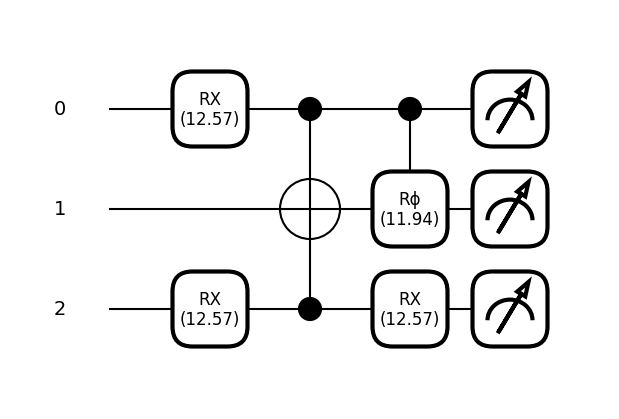

In [ ]:
backend = CircuitsPennylaneBackend()

qc = backend.genqc_to_backend(instructions, flip_qubit_order=False)
backend.draw(qc);

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()